## GMVPredict
<div style="font-size:0.8em;">Contacts:
<ul>
<li>William Yang, MRC Cognition and Brain Sciences Unit (wy279@cam.ac.uk)</li>
<li>Petar Raykov, MRC Cognition and Brain Sciences Unit (Petar.Raykov@mrc-cbu.cam.ac.uk)</li>
<li>Andrea Greve, MRC Cognition and Brain Sciences Unit (Andrea.Greve@mrc-cbu.cam.ac.uk)</li>
</ul>
</div>


### 1. Setup

In [571]:
# Load Packages
import numpy as np
from numpy import arange
from numpy import sqrt
import pandas as pd
import joblib
import pickle
import os
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.svm import LinearSVR, LinearSVC, SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA, KernelPCA
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from scipy.stats import pearsonr, mannwhitneyu, norm, zscore
import shap
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

# Helper functions
def flatten(t):
    return [item for sublist in t for item in sublist]

def continuous_predict(search, data):
    y_pred = search.predict(data)
    y_pred = y_train_mean + y_train_std*y_pred
    y_pred = np.clip(y_pred,0,None)

    return y_pred

def impute_continuous_data(X_train, X_CV, continuous_missing, impute_method='mean', knn_neighbors=None):
    if impute_method == 'mean':
        # Mean imputation for continuous variables
        imputer = SimpleImputer(strategy='mean')
    elif impute_method == 'knn':
        # KNN imputation for continuous variables
        imputer = KNNImputer(n_neighbors=knn_neighbors)
    else:
        raise ValueError("Invalid imputation method. Choose either 'mean' or 'knn'.")

    # Fitting and transforming the training data
    X_train[continuous_missing] = imputer.fit_transform(X_train[continuous_missing])
    # Transforming the validation data
    X_CV[continuous_missing] = imputer.transform(X_CV[continuous_missing])

    return X_train, X_CV

def r_to_z(r):
    return 0.5 * np.log((1 + r) / (1 - r))

def z_test(r1, r2, n):
    z1 = r_to_z(r1)
    z2 = r_to_z(r2)
    SE_diff = np.sqrt((1.0 / (n - 3)) + (1.0 / (n - 3)))
    z_diff = (z1 - z2) / SE_diff
    return z_diff

### 2. Loading Data

In [515]:
# Load Raw Data
raw_df = pd.read_csv('Source/MeanGrayVBM.csv', sep=',', header=0, index_col=0) # Dataframe with demographic and VBM ROI data (708 rows, 118 feature columns)
raw_df['Sex'] = raw_df['Sex'].replace({2: 0}) # 1 is male, 0 is female

### 3. Data Preprocessing & Cleaning

In [516]:
# Verifying all GMV values of R hippocampus (108) have accompanying values for L hippocampus (101)
mask_101 = raw_df['ROI_101'].notna()
mask_108 = raw_df['ROI_108'].isna()
problem_rows = raw_df[mask_101 & mask_108] # This is empty, so there are no problem rows

# Dropping rows with no hippocampal GMV
df = raw_df.dropna(subset=['ROI_101'])

# -----OPTIONAL: Adjust dataset to include total GM volume instead of average across ROI (i.e. percentage GM)-----
nvoxels = pd.read_csv('Source/Nvoxel_table.csv', sep=',', header=0, index_col=False) # Dataframe with number of voxels in each ROI
roi_columns = [col for col in raw_df.columns if 'ROI_' in col] # Selecting only the ROI volume columns and not age, sex etc
multiplier = nvoxels[roi_columns].iloc[0]
df[roi_columns] = df[roi_columns].mul(multiplier)

# Adding R hippocampus and L hippocampus volumes to make one outcome variable column
df['HippGMV'] = df['ROI_101'] + df['ROI_108']

# Checking if any na values for further cleaning
nan_locs = [(index, col) for index, row in df.iterrows() for col in df.columns if pd.isnull(row[col])]
# Uncomment and run below to see if length greater than 0 
# len(nan_locs)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### 4. Exploratory Data Analysis

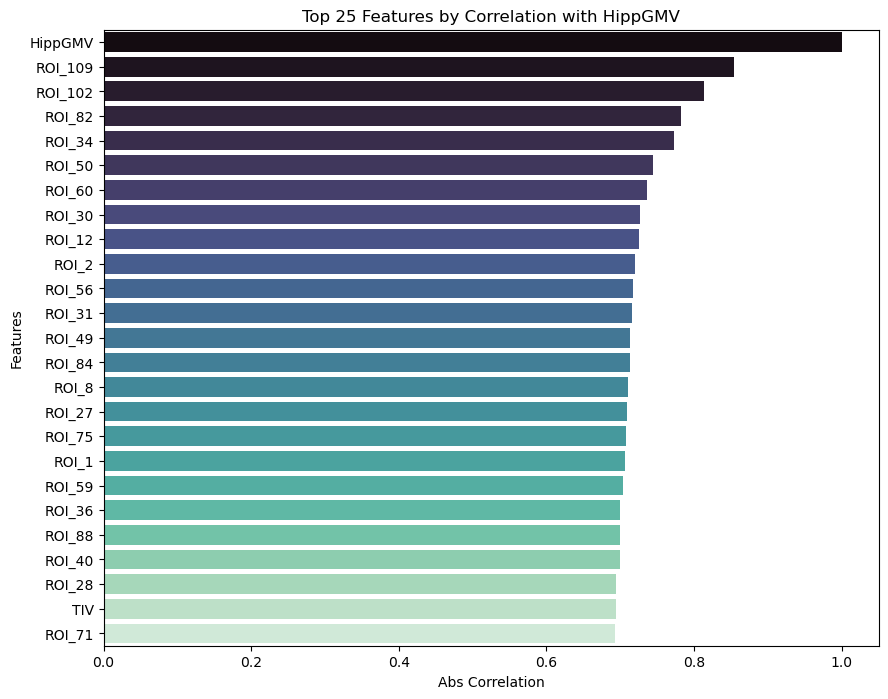

In [517]:
# Correlation matrix
df_dropped = df.drop(columns=['ROI_101', 'ROI_108']).dropna()
corr_matrix = df_dropped.corr()
corr_with_HippGMV = corr_matrix['HippGMV']

# Select top n features
top_N = 25  # Choose n
top_corr_with_HippGMV = corr_with_HippGMV.apply(abs).sort_values(ascending=False).head(top_N)

# Bar chart of top n features
plt.figure(figsize=(10, 8))
sns.barplot(x=top_corr_with_HippGMV.values, y=top_corr_with_HippGMV.index, palette='mako')
plt.title(f'Top {top_N} Features by Correlation with HippGMV')
plt.xlabel('Abs Correlation')
plt.ylabel('Features')
plt.show()

# -----------Reduced Model Creation-------------#


# # Histogram of feature correlations
# plt.figure(figsize=(10, 8))
# sns.histplot(corr_with_HippGMV.values, bins=30, kde=True)
# plt.xlabel('Correlation with HippGMV')
# plt.ylabel('Frequency')
# plt.title('Histogram of Correlation with HippGMV')
# plt.show()

# # Show scatterplot for every feature
# # for feature in df_select.columns:
# #     fig, ax = plt.subplots()
# #     ax.scatter(df_select[feature], df_select['HippGMV'])
# #     ax.set_xlabel(feature)
# #     ax.set_ylabel('HippGMV')
# #     ax.set_title(feature)
# #     plt.show()

# # Add a constant term to the X_train matrix
# X_train_with_const = sm.add_constant(X_train)

# # Fit the OLS (Ordinary Least Squares) model
# ols_model = sm.OLS(y_train, X_train_with_const)
# ols_results = ols_model.fit()

# # Get the confidence intervals for the coefficients
# conf_int = ols_results.conf_int()

# # Extract the coefficient names and values
# coefficient_names = conf_int.index
# coefficient_values = ols_results.params

# # Extract the coefficient names and values for the top N features
# top_N_features = top_corr_with_HippGMV.drop('HippGMV').index.tolist()
# coefficient_values = ols_results.params.loc[top_N_features]

# # Extract the lower and upper bounds of the confidence intervals for the top N features
# lower_bounds = conf_int.loc[top_N_features, 0]
# upper_bounds = conf_int.loc[top_N_features, 1]

# # Calculate the point estimates (mean) of the coefficients for the top N features
# point_estimates = coefficient_values

# # Calculate the lengths of the confidence intervals for the top N features
# interval_lengths = upper_bounds - lower_bounds

# # Create a horizontal bar plot for the top N features
# plt.barh(top_N_features, point_estimates, xerr=interval_lengths,
#          capsize=4, alpha=0.7)

# # Add labels and title
# plt.xlabel('Coefficient Estimate')
# plt.ylabel('Features')
# plt.title(f'Confidence Intervals for Coefficients (Top {top_N} Features)')

# # Show the plot
# plt.show()

# # Extract the features and target variable
# X_shap = df_dropped.drop('HippGMV', axis=1)
# y_shap = df_dropped['HippGMV']

# # Create a Linear Regression model
# model = LinearRegression()

# # Fit the model
# model.fit(X_shap, y_shap)

# # Initialize the SHAP explainer with your model and data
# explainer = shap.Explainer(model, X_shap)

# # Calculate the SHAP values
# shap_values = explainer(X_shap)

# # Get the feature importance values from shap.summary_plot
# feature_importance_values = np.abs(shap_values.values).mean(axis=0)

# # Create a DataFrame for plotting
# shap_df = pd.DataFrame({'Features': X_shap.columns, 'Importance': feature_importance_values})

# # Sort the DataFrame by importance values in descending order
# shap_df = shap_df.sort_values('Importance', ascending=False).head(top_N)

# # Create the bar plot using Seaborn
# plt.figure(figsize=(10, 8))
# sns.barplot(data=shap_df, x='Importance', y='Features', palette='rocket')
# plt.title("Features by Importance (Shapley Values)")
# plt.xlabel("Abs Shapley Value")
# plt.ylabel("Features")
# plt.tight_layout()
# plt.show()

# # Fit the model
# model.fit(X_shap, y_shap)

# # Initialize the SHAP explainer with your model and data
# explainer = shap.Explainer(model, X_shap)

# # Calculate the SHAP values
# shap_values = explainer(X_shap)

# # Plot the SHAP summary plot
# shap.summary_plot(shap_values, X_shap, plot_type='bar')



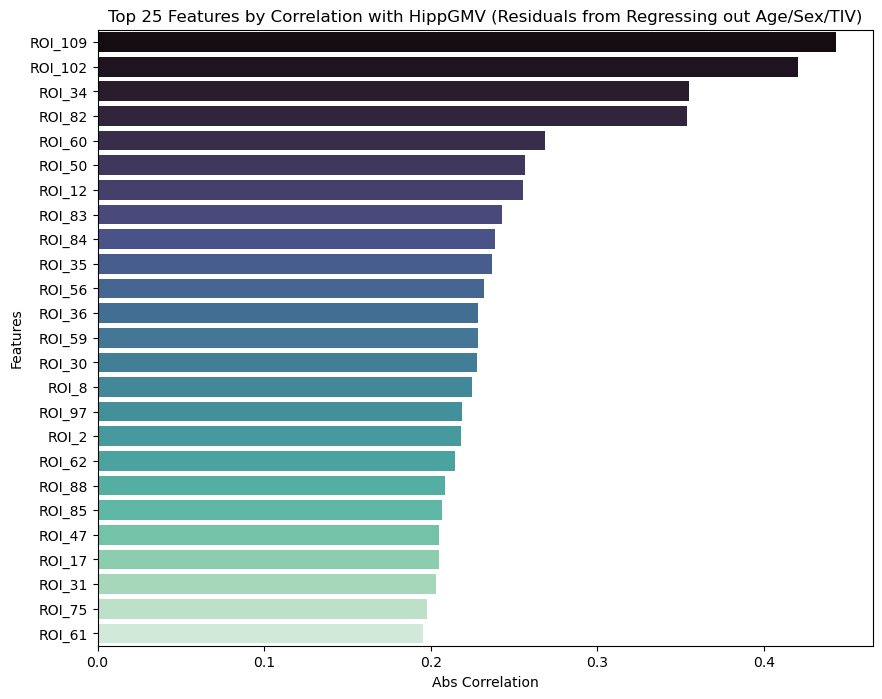

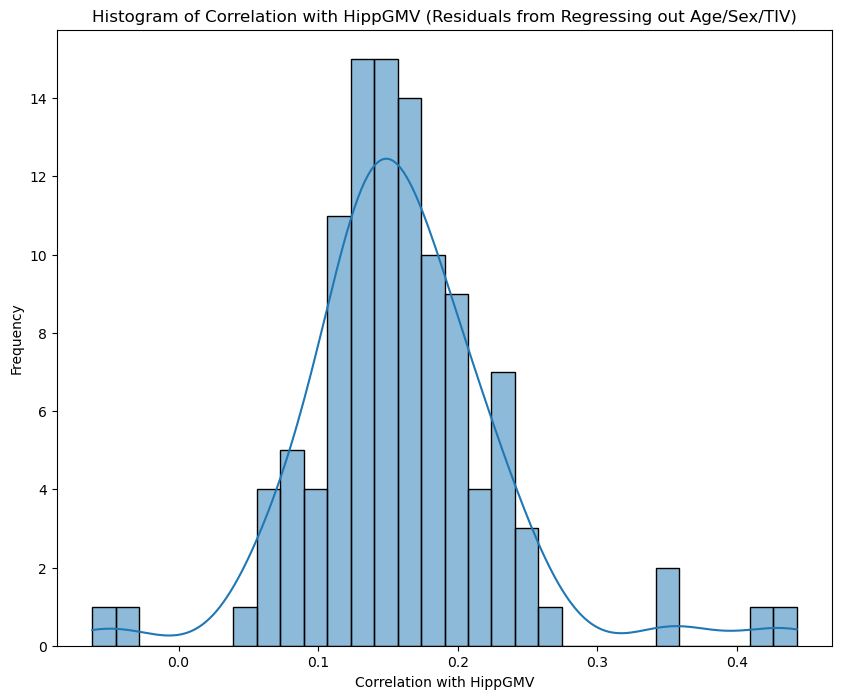

0.16012521188298237

In [518]:
# --------Regressing out effects of age, sex and TIV from each ROI---------

# Multiple linear regression to estimate relationship between each ROI vs. age/sex/TIV
base_features = ['Age', 'Sex', 'TIV']
X_reduced = df_dropped[base_features]
X_reduced = sm.add_constant(X_reduced)

# Prepare the target variable
y_reduced = df_dropped[['HippGMV']]

# Create a dictionary to store the residuals for each ROI
residuals_dict = {}

# Iterate over the columns starting with "ROI"
for column in df_dropped.columns:
    if column.startswith('ROI') and column not in ['Age', 'Sex', 'TIV', 'cattell', 'EM', 'Income', 'Education', 'ROI_101', 'ROI_108']:
        roi_column = df_dropped[column]

        # Fit the multiple linear regression model
        model = sm.OLS(roi_column, X_reduced)
        results = model.fit()

        # Obtain the residuals from the regression
        residuals = results.resid

        # Store the residuals in the dictionary using the column name as the key
        residuals_dict[column] = residuals

# Convert the residuals dictionary to a DataFrame
residuals_df = pd.DataFrame(residuals_dict)

# Compute pairwise correlations between residuals of each ROI vs. HippGMV
corr_with_HippGMV_residuals = {}
for roi_column in residuals_df.columns:
    # Perform correlation between residuals and HippGMV
    corr = np.corrcoef(residuals_df[roi_column], df_dropped['HippGMV'])[0, 1]
    corr_with_HippGMV_residuals[roi_column] = corr

# Convert the correlations to a pandas Series
corr_with_HippGMV_residuals = pd.Series(corr_with_HippGMV_residuals)

# Select top n features
top_corr_with_HippGMV_residuals = corr_with_HippGMV_residuals.apply(abs).sort_values(ascending=False).head(top_N)

# Bar chart of top n features
plt.figure(figsize=(10, 8))
sns.barplot(x=top_corr_with_HippGMV_residuals.values, y=top_corr_with_HippGMV_residuals.index, palette='mako')
plt.title(f'Top {top_N} Features by Correlation with HippGMV (Residuals from Regressing out Age/Sex/TIV)')
plt.xlabel('Abs Correlation')
plt.ylabel('Features')
plt.show()

# Histogram of residuals 
plt.figure(figsize=(10, 8))
sns.histplot(corr_with_HippGMV_residuals.values, bins=30, kde=True)
plt.xlabel('Correlation with HippGMV')
plt.ylabel('Frequency')
plt.title('Histogram of Correlation with HippGMV (Residuals from Regressing out Age/Sex/TIV)')
plt.show()

np.mean(corr_with_HippGMV_residuals)

### 5. Feature Selection

In [519]:
# Df has 653 rows and 118 features, which reduces depending on whether missing behavioral and demographic data is dropped

# df_full preserves all features (behavioral, demographic, GMV), then drops missing values. 597 rows.
df_full = df.dropna() 

# df_noincome preserves all features except Income, then drops missing values. 626 rows. 
# Rationale: some evidence suggests no significant association between hippocampal GMV and income. For a review see Farah, 2017
df_noincome = df.drop(columns=['Income'])

# df_nobehav preserves all features except cattell IQ, episodic memory, and income, then drops rest. 616 rows
df_nobehav_noincome = df.drop(columns=['cattell', 'EM', 'Income'])

# df_restrict datset only includes age, sex and MRI features. 648 rows after dropping missing values.
df_restrict = df.drop(columns=['cattell', 'EM', 'Education', 'Income']).dropna().drop(columns=['TIV'])

# ---------TOGGLE: df_select globally determines which df is used for EDA and ML analysis---------
df_select = df_restrict # Use one of the options above in this block

# Adding an indicator feature (imputation flag), because missing values may be distributed non-randomly
# missing_cols = df_select.columns[df_select.isnull().any()].tolist()
# if len(missing_cols) > 0:
#     df_select['impute'] = df_select[missing_cols].isnull().astype(int)

df_restrict.shape


(648, 114)

### 6. Train-Validation Split

In [520]:
# ---------TOGGLE: Globally specify target variable(s) for model training---------# 
targets = ['HippGMV'] # Can change or add more if needed, but make sure to edit feature_columns accordingly

# Defining features to be excluded from training
# Since we are predicting HippGMV, by default we exclude L, R and HIppGMV from training
feature_exclusion = targets.copy()
if 'HippGMV' in targets:
    for roi in ['ROI_101', 'ROI_108']: # Note HippGMV = ROI_101 + ROI_108
        if roi not in feature_exclusion:
            feature_exclusion.append(roi)

# Excluding L, R and bilateral hippocampal GMV from training
feature_columns = [col for col in df_select.columns if col not in feature_exclusion] 
X = df_select[feature_columns]
y = df_select[targets]

# Splitting data
X_train, X_CV, y_train, y_CV = train_test_split(X, y, test_size=0.2, random_state=0)

In [521]:
# # Uncomment and run below to see if length greater than 0 
# missing_val = X_train.isnull().sum()
# print(missing_val[missing_val > 0])

nas = df_select.isna().sum()
print(nas[nas>0])

# for column in df_select.columns:
#     for index, value in df_select[column].items():
#         if pd.isnull(value):
#             print(f"Missing value at index {index} in column {column}")


Series([], dtype: int64)


### 7. Feature Engineering

In [522]:
# Squaring age in the X datasets, due to evidence of a quadratic relationship between age and GMV
X_train['Age_squared'] = X_train['Age']**2
X_train.insert(0, 'Age_squared', X_train.pop('Age_squared'))
X_CV['Age_squared'] = X_CV['Age']**2
X_CV.insert(0, 'Age_squared', X_CV.pop('Age_squared'))

# # Defining ordinal and continuous columns with missing values
# ordinal_missing = []
# continuous_missing = ['TIV']

# X_train_ordinal = X_train[ordinal_missing]
# X_train_cont = X_train[continuous_missing]

# # Calculate imputed values for ordinal feature
# ordinal_impute = X_train.median()[X_train_ordinal.columns]

# # Impute ordinal values 
# X_train = X_train.fillna(ordinal_impute)
# X_CV = X_CV.fillna(ordinal_impute)

# #---------K-Nearest Neighbors Imputation for Continuous Missing Values---------#

# # Search space range for neighbors
# neighbors = list(range(1, 20))

# # Initialize results list
# knn_cv_scores = []

# # Cross-validation for KNN Imputer based on number of neighbors
# for k in neighbors:
#     # Impute continuous data with KNN and specified number of neighbors
#     X_train_imputed, X_CV_imputed = impute_continuous_data(X_train, X_CV, continuous_missing, impute_method='knn', knn_neighbors=k)

#     # Use Linear Regression as model for CV 
#     model = XGBRegressor()
#     scores = cross_val_score(model, X_train_imputed, y_train, cv=5, scoring='neg_mean_squared_error')
#     knn_cv_scores.append(scores.mean())

# # Calculate RMSE for each number of neighbors
# rmse_scores = [sqrt(abs(score)) for score in knn_cv_scores]

# # Find number of neighbors giving the smallest RMSE
# optimal_k = neighbors[rmse_scores.index(min(rmse_scores))]

# # Using imputation for continuous variables
# X_train, X_CV = impute_continuous_data(X_train, X_CV, continuous_missing, impute_method='knn', knn_neighbors=optimal_k)

# Ensuring no missing values left 
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_CV = X_CV.dropna()
y_CV = y_CV.loc[X_CV.index]

# Copying data
X_train_main = X_train.copy()
y_train_main = y_train.copy()
X_CV_main = X_CV.copy()
y_CV_main = y_CV.copy()

# Pickling train-validation data
if os.path.exists('Models') == False: os.makedirs('Models')
pickle.dump(X_train_main, open('Models/X_train_main.pkl', 'wb'))
pickle.dump(y_train_main, open('Models/y_train_main.pkl', 'wb'))
pickle.dump(X_CV_main, open('Models/X_CV_main.pkl', 'wb'))
pickle.dump(y_CV_main, open('Models/y_CV_main.pkl', 'wb'))

### 7. Baseline Models

#### 7.1 Training Baseline Models

In [523]:
# Performance of reduced model with just base features (Age, Sex, TIV)
# X_train_reduced = X_train[base_features]
# X_CV_reduced = X_CV[base_features]

# reduced_model = LinearRegression()
# reduced_model.fit(X_train_reduced, y_train)

# reduced_train = reduced_model.score(X_train_reduced, y_train)
# reduced_cv = reduced_model.score(X_CV_reduced, y_CV)  

# print("R2 score on training data:", reduced_train)
# print("R2 score on CV data:", reduced_cv)

In [524]:
# Open train-validation data
X_train_main = pickle.load(open('Models/X_train_main.pkl','rb'))
y_train_main = pickle.load(open('Models/y_train_main.pkl','rb'))
# y_train_main = y_train_main.to_frame()
X_CV_main = pickle.load(open('Models/X_CV_main.pkl','rb'))
y_CV_main = pickle.load(open('Models/y_CV_main.pkl','rb'))
# y_CV_main = y_CV_main.to_frame()

# Training baseline models
if os.path.exists('Models/baselines') == False: os.makedirs('Models/baselines')

for target in targets:    
    # Ensuring missing values are dropped before training
    y_train = y_train_main[target]
    X_train = X_train_main.loc[y_train.index.values]

    # Z-score standardization of y variable
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train_trans = (y_train-y_train_mean)/y_train_std
    y_train = y_train_trans
    
    models = [LinearRegression(), Lasso(random_state = 0), Ridge(random_state = 0), ElasticNet(random_state = 0), RandomForestRegressor(random_state = 0), XGBRegressor(), SVR()]
    for model in tqdm(models):
        model.fit(X_train, y_train)
        model_name = model.__class__.__name__ # Retrieves model class name to make file name shorter (needed for XGBoost)
        try:
            if (type(model).__name__ == 'XGBRegressor'): fname = f'Models/baselines/{target}_{model_name}.pkl'
            else: fname = f'Models/baselines/{target} {str(model)}.pkl'
        except:
            continue
        joblib.dump(model, fname)

100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


#### 7.2 Baseline Model Results

In [525]:
# Baseline results

results_baseline = pd.DataFrame()
# y = y.to_frame()

for target in targets:
    # Ensuring missing values are dropped before training
    y_train = y_train_main[target]
    X_train = X_train_main.loc[y_train.index.values]

    vars = []
    model_type = []
    train_r2 = []
    cv_r2 = []
    train_rmse = []
    cv_rmse = []
    n_features = []
    
    models = [LinearRegression(), Lasso(random_state = 0), Ridge(random_state = 0), ElasticNet(random_state = 0), RandomForestRegressor(random_state = 0), XGBRegressor(), SVR()]
    for model in models:
        model_name = model.__class__.__name__ # Retrieves model class name to make file name shorter (needed for XGBoost)
        try:
            if (type(model).__name__ == 'XGBRegressor'): model = joblib.load(f'Models/baselines/{target}_{model_name}.pkl')
            else: model = joblib.load(f'Models/baselines/{target} {str(model)}.pkl')
        except:
            continue

        vars.append(target)
        model_type.append(type(model).__name__)

        y_pred = continuous_predict(model, X_train)
        train_r2.append(r2_score(y_train, y_pred))
        train_rmse.append(np.sqrt(mean_squared_error(y_train, y_pred)))

        y_pred = continuous_predict(model, X_CV)
        cv_r2.append(r2_score(y_CV, y_pred))
        cv_rmse.append(np.sqrt(mean_squared_error(y_CV, y_pred)))

    results_baseline2 = pd.DataFrame({'variable': vars, 'model': model_type, 'train_r2': train_r2, 'cv_r2': cv_r2, 'train_rmse': train_rmse, 'cv_rmse': cv_rmse})
    results_baseline = pd.concat([results_baseline, results_baseline2], axis=0).reset_index(drop=True)
results_baseline = results_baseline.round(3)
results_baseline


,variable,model,train_r2,cv_r2,train_rmse,cv_rmse
0,HippGMV,LinearRegression,0.857,0.764,36.082,46.539
1,HippGMV,Lasso,0.814,0.773,41.052,45.699
2,HippGMV,Ridge,0.857,0.764,36.083,46.540
3,HippGMV,ElasticNet,0.834,0.782,38.812,44.795
4,HippGMV,RandomForestRegressor,0.964,0.740,18.108,48.922
5,HippGMV,XGBRegressor,1.000,0.718,0.043,50.945
6,HippGMV,SVR,0.658,0.694,55.738,53.090


In [526]:
# # Create a scatter plot
# plt.scatter(X_train['TIV'], y_train, c=np.where(X_train['impute'] == 1, 'red', 'blue'))

# # Set labels and title
# plt.xlabel('TIV')
# plt.ylabel('HippGMV')
# plt.title('Scatter Plot: TIV vs HippGMV')

# # Show the plot
# plt.show()

# # Calculate the Pearson correlation coefficient
# correlation, _ = pearsonr(X_train['TIV'], y_train)

# # Print the correlation coefficient
# print('Pearson correlation coefficient (r):', correlation)

### 8. Hyperparameter Optimization

#### 8.1 Tuning with Bayesian Search

In [527]:
# # Set directory for pickling Bayesian Search model
# if os.path.exists('Models/bayesiansearch') == False: os.makedirs('Models/bayesiansearch')

# for target in targets:
#     # Ensuring missing values are dropped before training
#     y_train = y_train_main[target].dropna()
#     X_train = X_train_main.loc[y_train.index.values]

#     # Z-score standardization of y variable 
#     y_train_mean = y_train.mean()
#     y_train_std = y_train.std()
#     y_train_trans = (y_train-y_train_mean)/y_train_std
#     y_train = y_train_trans

#     # Initialize preprocessing objects
#     cols = list(X_train.columns)
#     preprocessor = ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough')
#     skb = SelectKBest(score_func=mutual_info_regression)

#     # Initialize estimators
#     model1 = ElasticNet(random_state = 0)
#     model2 = XGBRegressor()
#     model3 = RandomForestRegressor(random_state = 0)

#     # Create pipeline
#     pipe = Pipeline(steps=[('preprocessor', preprocessor), ('skb', skb), ('model', model1)])
    
#     # Initialize hyperparameters for elasticnet
#     param1 = {}
#     param1['preprocessor__standard'] = Categorical([ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough'), ColumnTransformer([('standard', StandardScaler(), cols)], remainder='passthrough')])
#     param1['skb__k'] = Integer(10, len(X_train.columns), "log-uniform")
#     # param1['model__max_iter'] = Integer(1000, 5000)
#     param1['model__alpha'] = Real(0.001, 10)
#     param1['model__l1_ratio'] = Real(0, 1)
#     param1['model'] = Categorical([model1])

#     # Run Bayesian Search for elasticnet
#     params = [param1]
#     search = BayesSearchCV(pipe, params, scoring='neg_mean_squared_error', cv = 3, verbose = 1, n_iter = 100, n_jobs = -1)
#     search.fit(X_train, y_train)
#     fname = f'Models/bayesiansearch/{target} elasticnet bayesian.pkl'
#     joblib.dump(search, fname)

#     # Initialize the hyperparameters for XGBoost
#     param2 = {}
#     param2['preprocessor__standard'] = Categorical([ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough'), ColumnTransformer([('standard', StandardScaler(), cols)], remainder='passthrough')])
#     param2['skb__k'] = Integer(10, len(X_train.columns), "log-uniform")
#     param2['model__gamma'] = Real(0.001, 10.0)
#     param2['model__min_child_weight'] = Integer(1, 20)
#     param2['model__learning_rate'] = Real(0.01, 0.3)
#     param2['model__colsample_bytree'] = Real(0.4, 0.8)
#     param2['model__subsample'] = Real(0.4, 0.8)
#     param2['model__n_estimators'] = list(range(50, 1001, 50))
#     param2['model__max_depth'] = Integer(1, 10)
#     param2['model'] = Categorical([model2])

#     # Run Bayesian Search for XGBoost
#     params = [param2]
#     search = BayesSearchCV(pipe, params, scoring='neg_mean_squared_error', cv = 3, verbose = 1, n_iter = 100, n_jobs = -1)
#     search.fit(X_train, y_train)
#     fname = f'Models/bayesiansearch/{target} xgboost bayesian.pkl'
#     joblib.dump(search, fname)

#     # Initialize the hyperparameters for randomforest
#     param3 = {}
#     param3['preprocessor__standard'] = Categorical([ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough'), ColumnTransformer([('standard', StandardScaler(), cols)], remainder='passthrough')])
#     param3['skb__k'] = Integer(10, len(X_train.columns), "log-uniform")
#     param3['model__max_features'] = Categorical(['sqrt', 'log2'])
#     param3['model__n_estimators'] = Integer(100, 1000)
#     param3['model__max_depth'] = Integer(1,120)
#     param3['model'] = [model3]

#     # Run Bayesian Search for randomforest
#     params = [param3]
#     search = BayesSearchCV(pipe, params, scoring='neg_mean_squared_error', cv = 3, verbose = 1, n_iter = 100, n_jobs = -1)
#     search.fit(X_train, y_train)
#     fname = f'Models/bayesiansearch/{target} randomforest bayesian.pkl'
#     joblib.dump(search, fname)


#### 8.2 Tuning with Randomized Search

In [528]:
# # Set directory for pickling Randomized Search models
# if os.path.exists('Models/randomizedsearch') == False: os.makedirs('Models/randomizedsearch')

# for target in targets:
#     # Ensuring missing values are dropped before training
#     y_train = y_train_main[target].dropna()
#     X_train = X_train_main.loc[y_train.index.values]

#     # Z-score standardization of y variable 
#     y_train_mean = y_train.mean()
#     y_train_std = y_train.std()
#     y_train_trans = (y_train-y_train_mean)/y_train_std
#     y_train = y_train_trans

#     # Initialize preprocessing objects
#     cols = list(X_train.columns)
#     preprocessor = ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough')
#     skb = SelectKBest(score_func=mutual_info_regression)

#     # Initialize estimators
#     model1 = ElasticNet(random_state = 0)
#     model2 = XGBRegressor()
#     model3 = RandomForestRegressor(random_state = 0)

#     # Create pipeline
#     pipe = Pipeline(steps=[('preprocessor', preprocessor), ('skb', skb), ('model', model1)])

#     # Initialize hyperparameters for elasticnet
#     param1 = {}
#     param1['preprocessor__standard'] = [ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough'), ColumnTransformer([('standard', StandardScaler(), cols)], remainder='passthrough')]
#     param1['skb__k'] = [35, 40, 45, 50, 55, 60, len(X_train.columns)] # best performer (r2=0.806) uses 50
#     # param1['model__max_iter'] = range(1000, 5000) # best performer (r2=0.806) uses 1096
#     param1['model__alpha'] = np.logspace(-4, 2, num=10) # best performer (r2=0.806) uses 1
#     param1['model__l1_ratio'] = arange(0, 1.01, 0.01) # best performer (r2=0.806) uses 0.29
#     param1['model'] = [model1]

#     # Run Randomized Search for elasticnet
#     params = [param1]
#     search = RandomizedSearchCV(pipe, params, n_jobs=-1, scoring='neg_mean_squared_error', cv = 3, verbose = 1, n_iter = 500)
#     search.fit(X_train, y_train)
#     fname = f'Models/randomizedsearch/{target} elasticnet randomized.pkl'
#     joblib.dump(search, fname)

#     # Initialize the hyperparameters for XGBoost
#     param2 = {}
#     param2['preprocessor__standard'] = [ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough'), ColumnTransformer([('standard', StandardScaler(), cols)], remainder='passthrough')]
#     param2['skb__k'] = [35, 40, 45, 50, 55, 60, len(X_train.columns)]
#     param2['model__max_depth'] = np.arange(1, 10, 1)
#     param2['model__learning_rate'] = np.arange(0.01, 0.1, 0.01)
#     param2['model__subsample'] = np.arange(0.6, 1.0, 0.1)
#     param2['model__n_estimators'] = np.arange(100, 1000, 100)
#     param2['model'] = [model2]

#     # Run Randomized Search for XGBoost
#     params = [param2]
#     search = RandomizedSearchCV(pipe, params, n_jobs=-1, scoring='neg_mean_squared_error', cv = 3, verbose = 1, n_iter = 100)
#     search.fit(X_train, y_train)
#     fname = f'Models/randomizedsearch/{target} xgboost randomized.pkl'
#     joblib.dump(search, fname)

#     # Initialize the hyperparameters for randomforest
#     param3 = {}
#     param3['preprocessor__standard'] = [ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough'), ColumnTransformer([('standard', StandardScaler(), cols)], remainder='passthrough')]
#     param3['skb__k'] = [10, 15, 20, 25, 30, 40, 50, 75, len(X_train.columns)]
#     param3['model__max_features'] = ['auto', 'sqrt']
#     param3['model__n_estimators'] = np.arange(100, 1000, 100)
#     param3['model__max_depth'] = np.arange(0, 120, 10)
#     param3['model'] = [model3]

#     # Run Randomized Search for randomforest
#     params = [param3]
#     search = RandomizedSearchCV(pipe, params, n_jobs=-1, scoring='neg_mean_squared_error', cv = 3, verbose = 1, n_iter = 100)
#     search.fit(X_train, y_train)
#     fname = f'Models/randomizedsearch/{target} randomforest randomized.pkl'
#     joblib.dump(search, fname)

### 9. Model Evaluation

In [529]:
# Results of Hyperoptimization
results_tuned = pd.DataFrame()

for target in targets:
    # Ensuring missing values are dropped before training
    y_train = y_train_main[target].dropna()
    X_train = X_train_main.loc[y_train.index.values]

    # Drop NA for CV
    y_CV = y_CV_main[target].dropna()
    X_CV = X_CV_main.loc[y_CV.index.values]

    vars = []
    search_type =[]
    model_type = []
    scaler = []
    n_features = []
    params = []
    train_r2 = []
    cv_r2 = []
    train_rmse = []
    cv_rmse = []
    
    searches = ['randomizedsearch','bayesiansearch', 'gridsearch']
    models = ['elasticnet', 'randomforest', 'xgboost']
    for searchcv in searches:
        for model in models: 
            # Read model, calculate scores, store in a dataframe
            try:
                search = joblib.load(f'Models/{searchcv}/{target} {model} {searchcv[:-6]}.pkl')
                # Models/bayesiansearch/{target} elasticnet bayesian.pkl
            except:
                continue
            
            vars.append(target)
            search_type.append(searchcv)
            model_type.append(type(search.best_params_['model']).__name__)

            # Get model params
            if '[]' in str(search.best_params_['preprocessor__standard']): scaler.append('none')
            else: scaler.append('ordinal + continuous')

            n_features.append(search.best_params_['skb__k'])

            model_params = [key for key in search.best_params_.keys() if key != 'model' and key[0:5] == 'model']
            model_params.sort()
            model_params = {key[7:] : search.best_params_[key] for key in model_params}
            params.append(model_params)

            y_pred = continuous_predict(search, X_train)
            train_r2.append(r2_score(y_train, y_pred))
            train_rmse.append(np.sqrt(mean_squared_error(y_train, y_pred)))      

            y_pred = continuous_predict(search, X_CV)
            cv_r2.append(r2_score(y_CV, y_pred))
            cv_rmse.append(np.sqrt(mean_squared_error(y_CV, y_pred)))

    results_tuned1 = pd.DataFrame({'variable': vars, 'search': search_type, 'model': model_type, 'scaler' : scaler, 'n_features' : n_features, 'params' : params, 'train_r2': train_r2, 'cv_r2': cv_r2, 'train_rmse': train_rmse, 'cv_rmse': cv_rmse})
    results_tuned = pd.concat([results_tuned, results_tuned1], axis=0).reset_index(drop=True)
results_tuned = results_tuned.round(3)
results_tuned

,variable,search,model,scaler,n_features,params,train_r2,cv_r2,train_rmse,cv_rmse
0,HippGMV,randomizedsearch,ElasticNet,ordinal + continuous,50,"{'alpha': 1.0, 'l1_ratio': 0.49, 'max_iter': 1...",0.805,0.775,42.018,45.460
1,HippGMV,randomizedsearch,RandomForestRegressor,none,25,"{'max_depth': 80, 'max_features': 'sqrt', 'n_e...",0.965,0.748,17.776,48.160
2,HippGMV,randomizedsearch,XGBRegressor,none,50,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.954,0.732,20.347,49.623
3,HippGMV,bayesiansearch,ElasticNet,none,42,"{'alpha': 1.26793966687152, 'l1_ratio': 0.5826...",0.790,0.761,43.602,46.859
4,HippGMV,bayesiansearch,RandomForestRegressor,ordinal + continuous,10,"{'max_depth': 22, 'max_features': 'log2', 'n_e...",0.965,0.744,17.713,48.533
5,HippGMV,bayesiansearch,XGBRegressor,ordinal + continuous,111,"{'colsample_bytree': 0.8, 'gamma': 0.001, 'lea...",0.921,0.758,26.693,47.169


In [530]:
# print(results_tuned['params'][0])
# print(results_tuned['params'][1])
# print(results_tuned['params'][2])

### 10. Loading & Processing Patient Data

In [531]:
# Loading data and multiplying by nvoxels to get total GMV of each ROI
patient_source_df = pd.read_csv('Source/patient_data.csv', sep=',', header=0, index_col=0)
patient_roi_df = patient_source_df.iloc[:, 0:111]
nvoxels = pd.read_csv('Source/Nvoxel_table.csv', sep=',', header=0, index_col=False) # Dataframe with number of voxels in each ROI
roi_columns = [col for col in patient_roi_df.columns if 'ROI_' in col] # Selecting only the ROI volume columns and not age, sex etc
multiplier = nvoxels[roi_columns].iloc[0]
patient_roi_df[roi_columns] = patient_roi_df[roi_columns].mul(multiplier)

# Loading demographic data
demo_df = pd.read_csv('Source/Subject_Demographics.csv', sep=',', header=0, index_col=0)
# Contatenating the two
patient_df = pd.concat([patient_roi_df.reset_index(drop=True), demo_df.reset_index(drop=True)], axis=1)

# Changing index range, column order
patient_df.index = range(1, 106)
cols = list(patient_df.columns)
cols.insert(0, cols.pop(cols.index('Label')))
patient_df = patient_df[cols]

# Adding Patient column 
patient_df.insert(1, 'Patient', patient_df['Label'].apply(lambda x: 1 if x.startswith('P') else (0 if x.startswith('S') else None)))

# Rounding ages
patient_df['Age'] = patient_df['age_at_scanning'].round(2) 
cols = list(patient_df.columns)
cols.insert(2, cols.pop(cols.index('Age')))
patient_df = patient_df[cols]

# Renaming sex column
patient_df = patient_df.rename(columns={'sex': 'Sex'})

# Combining L and R Hipp into one and removing the individual ones
patient_df['HippGMV'] = patient_df['ROI_101'] + patient_df['ROI_108']
patient_df = patient_df.drop(columns=['ROI_101', 'ROI_108'])

# Checking how many missing values there are
nan_locs = [(index, col) for index, row in patient_df.iterrows() for col in patient_df.columns if pd.isnull(row[col])]

roi_col = [col for col in patient_df.columns if 'ROI' in col]
columns_to_select = ['Age', 'Sex'] + roi_col + ['HippGMV']

# Get the new dataframe
new_patient_df = patient_df[columns_to_select]

# Selecting only 
controls = new_patient_df[patient_df['Patient'] == 0]
patients = new_patient_df[patient_df['Patient'] == 1]




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [532]:
# Making X and Y
feature_columns = [col for col in df_select.columns if col not in feature_exclusion] 
X_controls = controls[feature_columns]
y_controls = controls[targets]
X_patients = patients[feature_columns]
y_patients = patients[targets]
X_controls['Age_squared'] = X_controls['Age'] ** 2
X_patients['Age_squared'] = X_patients['Age'] ** 2
X_controls.insert(0, 'Age_squared', X_controls.pop('Age_squared'))
X_patients.insert(0, 'Age_squared', X_patients.pop('Age_squared'))


### 11. Model Testing

In [533]:
# Baseline results

results_test = pd.DataFrame()

for target in targets:
    # Ensuring missing values are dropped before training
    if not isinstance(y_controls, pd.DataFrame):
        y_controls = pd.DataFrame(y_controls)
    if not isinstance(y_patients, pd.DataFrame):
        y_patients = pd.DataFrame(y_patients)
    
    y_controls = y_controls[target]
    X_controls = X_controls.loc[y_controls.index.values]
    y_patients = y_patients[target]
    X_patients = X_patients.loc[y_patients.index.values]

    vars = []
    model_type = []
    controls_r2 = []
    controls_rmse = []
    patients_r2 = []
    patients_rmse = []
    n_features = []
    
    models = [LinearRegression(), Lasso(random_state = 0), Ridge(random_state = 0), ElasticNet(random_state = 0), RandomForestRegressor(random_state = 0), XGBRegressor(), SVR()]
    for model in models:
        model_name = model.__class__.__name__ # Retrieves model class name to make file name shorter (needed for XGBoost)
        try:
            if (type(model).__name__ == 'XGBRegressor'): model = joblib.load(f'Models/baselines/{target}_{model_name}.pkl')
            else: model = joblib.load(f'Models/baselines/{target} {str(model)}.pkl')
        except:
            continue

        vars.append(target)
        model_type.append(type(model).__name__)

        # y_pred = continuous_predict(model, X_train)
        # train_r2.append(r2_score(y_train, y_pred))
        # train_rmse.append(np.sqrt(mean_squared_error(y_train, y_pred)))

        y_pred_controls = continuous_predict(model, X_controls)
        controls_r2.append(r2_score(y_controls, y_pred_controls))
        controls_rmse.append(np.sqrt(mean_squared_error(y_controls, y_pred_controls)))
    
        y_pred_patients = continuous_predict(model, X_patients)
        patients_r2.append(r2_score(y_patients, y_pred_patients))
        patients_rmse.append(np.sqrt(mean_squared_error(y_patients, y_pred_patients)))

        delta_controls = y_pred_controls - y_controls
        delta_patients = y_pred_patients - y_patients

    results_test2 = pd.DataFrame({'variable': vars, 'model': model_type, 'controls_r2': controls_r2, 'controls_rmse': controls_rmse, 'patients_r2': patients_r2, 'patients_rmse': patients_rmse})
    results_test = pd.concat([results_test, results_test2], axis=0).reset_index(drop=True)
results_test = results_test.round(3)
results_test


,variable,model,controls_r2,controls_rmse,patients_r2,patients_rmse
0,HippGMV,LinearRegression,0.740,51.112,0.517,111.990
1,HippGMV,Lasso,0.750,50.179,0.486,115.532
2,HippGMV,Ridge,0.740,51.116,0.517,111.977
3,HippGMV,ElasticNet,0.770,48.133,0.506,113.227
4,HippGMV,RandomForestRegressor,0.644,59.887,0.242,140.235
5,HippGMV,XGBRegressor,0.626,61.389,0.204,143.721
6,HippGMV,SVR,0.604,63.152,-0.015,162.329


### 12. PCA

In [534]:
# PCA on neuropsych tests
pca_df = patient_df[patient_df['Patient'] == 1]
memory_columns = [col for col in pca_df.columns if 'paper' in col and 'minus' not in col]
# memory_columns = [col for col in pca_df.columns if 'paper' in col and 'verbal' not in col and 'visual' not in col]
# memory_columns = [col for col in pca_df.columns if 'paper' in col and 'visual' not in col]
pca_df = pca_df[memory_columns].dropna() # gets us 38x10 matrix. 10 features, 38 samples.

# PCA Settings
nc = 3
pca = PCA(n_components = nc)
kpca = KernelPCA(n_components=nc, kernel='rbf', gamma=None, fit_inverse_transform=True)

In [535]:
# Optimizing Kernel PCA:

# Split the data into training and validation set
PCA_train, PCA_val = train_test_split(pca_df, test_size=0.2, random_state=42)

gamma_values = np.logspace(-10, 1, 100)  # revise search space
best_gamma = None
lowest_reconstruction_error = float('inf')

for gamma in gamma_values:
    # Train KernelPCA on training data
    PCA_train_kpca = kpca.fit_transform(PCA_train)
    
    # Project validation data onto the training PCA space
    PCA_val_kpca = kpca.transform(PCA_val)
    
    # Reconstruct validation data from its KernelPCA projection
    PCA_val_reconstructed = kpca.inverse_transform(PCA_val_kpca)
    
    # Compute reconstruction error
    reconstruction_error = mean_squared_error(PCA_val, PCA_val_reconstructed)
    
    # Update best gamma if needed
    if reconstruction_error < lowest_reconstruction_error:
        best_gamma = gamma
        lowest_reconstruction_error = reconstruction_error

# print(f"Best gamma: {best_gamma}")


In [536]:
# Fit and transform the data
# Use best_gamma
kpca = KernelPCA(n_components=nc, kernel='rbf', gamma=best_gamma, fit_inverse_transform=True)

# Use kpca.fit_transform for kpca, pca.fit_transform for simple PCA
pca_model = kpca.fit_transform(pca_df)

# Convert the principal components into a DataFrame for easier manipulation
reconstructed_df = pd.DataFrame(data=pca_model, columns=['PC1', 'PC2', 'PC3'], index=pca_df.index)

In [537]:
## EXPLAINED VARIANCE (can only be calculated for linear simple PCA)

# explained_var = kpca.explained_variance_ratio_

# # Create a bar chart 
# plt.bar(range(1, len(explained_var) + 1), explained_var)
# plt.xlabel('Principal Component')
# plt.ylabel('Variance Explained')
# plt.title('Explained Variance by Principal Component')
# plt.xticks(range(1, len(explained_var) + 1))
# plt.show()

# # Extract the loadings
# loadings = pca.components_
# loadings_df = pd.DataFrame(data=loadings, columns=memory_columns, index=['PC1', 'PC2', 'PC3'])
# loadings_df

In [538]:
patients['y_pred'] = y_pred_patients
patients['volumelost'] = patients['y_pred'] - patients['HippGMV']
patients = pd.concat([patients, reconstructed_df], axis=1).dropna()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [539]:
patient_correlations = patients[['HippGMV', 'volumelost', 'PC1', 'PC2', 'PC3']].corr()
volumelost_to_pc_corr = patient_correlations.loc['volumelost', ['PC1', 'PC2', 'PC3']]
hippgmv_to_pc_corr = patient_correlations.loc['HippGMV', ['PC1', 'PC2', 'PC3']]

In [554]:
patient_df

,Label,Patient,Age,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7,...,le_paper_verbal_recog_3_subtests_z,le_paper_verbal_recall_minus_verbal_recog_z,le_paper_visual_recall_immediate_and_delayed_3_subtests_z,le_paper_visual_recog_2_subtests_z,le_paper_visual_recall_minus_visual_recog_z,cnsls_crying_sad,HADS_D,AMI_remote_autobiographical_sum,doors_and_people_visual_forget_z,HippGMV
1,S1,0,75.36,2819.602771,689.773143,880.473463,1153.474122,301.455674,339.666159,1563.632630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,894.104144
2,S2,0,73.23,2507.873072,584.336406,984.486028,963.620229,247.785788,256.634306,1531.300226,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,845.706016
3,S3,0,78.05,2968.939637,670.439627,1107.078575,1179.890093,316.745884,285.759777,1677.271303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,998.577332
4,S4,0,71.61,2602.026988,580.221388,958.266092,1104.561618,236.816914,241.623100,1323.667672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,756.599519
5,S5,0,64.70,3243.962473,759.310015,1309.544459,1245.673250,389.022035,282.291900,1712.845242,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1039.454182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,P101,1,53.83,2168.837088,588.639869,932.951016,886.302694,227.055456,294.245457,1565.293812,...,-1.446667,-0.753333,-2.890000,-1.330000,-1.560000,NaN,10.0,4.0,-2.00,807.880975
102,P102,1,75.07,1976.101338,615.848226,790.036642,890.842581,243.894715,289.961331,1074.528786,...,-0.890000,-0.442000,-1.163333,-0.937564,-0.225769,9.0,2.0,6.0,0.33,651.781966
103,P103,1,65.32,3625.325918,830.699147,1412.588807,1259.739150,307.646062,403.661182,1974.910251,...,0.556667,-0.756667,1.270000,0.670000,0.600000,NaN,3.0,18.0,-1.33,1114.389613
104,P104,1,60.49,2482.585604,642.612312,1259.613321,1189.624827,265.186366,301.128809,1651.031202,...,0.553333,-1.555333,0.436667,-0.537703,0.974369,NaN,14.0,10.0,-2.67,617.554644


In [560]:
sampledf = patient_df.dropna()
sampledf = sampledf[['le_paper_verbal_recog_3_subtests_z', 'HippGMV']]
corrs2 = sampledf[['le_paper_verbal_recog_3_subtests_z', 'HippGMV']].corr()
corrs2

,le_paper_verbal_recog_3_subtests_z,HippGMV
le_paper_verbal_recog_3_subtests_z,1.000000,0.333918
HippGMV,0.333918,1.000000


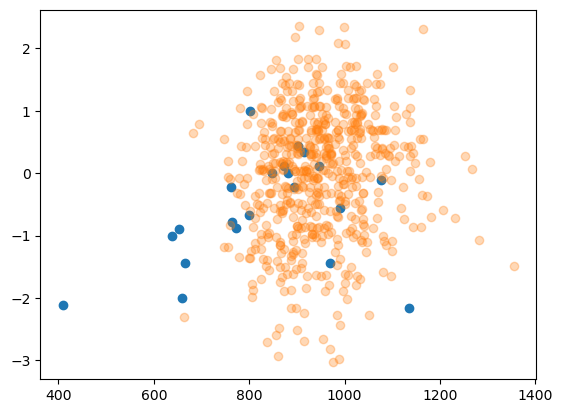

In [579]:
plt.scatter(sampledf['HippGMV'], sampledf['le_paper_verbal_recog_3_subtests_z'])
plt.scatter(abc['HippGMV'], memorydf,alpha=0.3)

In [577]:
# plt.scatter(abc['HippGMV'], abc['EM'])

memorydf = abc['EM']
memorydf = memorydf.to_frame()

memorydf = memorydf.apply(zscore)

In [540]:
patient_correlations

,HippGMV,volumelost,PC1,PC2,PC3
HippGMV,1.000000,-0.894268,-3.378704e-01,2.505499e-01,-4.578579e-02
volumelost,-0.894268,1.000000,3.563520e-01,-1.128839e-01,3.692202e-02
PC1,-0.337870,0.356352,1.000000e+00,-6.154923e-17,-2.788425e-16
PC2,0.250550,-0.112884,-6.154923e-17,1.000000e+00,-4.386529e-14
PC3,-0.045786,0.036922,-2.788425e-16,-4.386529e-14,1.000000e+00


In [541]:
# components = ['PC1', 'PC2', 'PC3']
# # Significance of difference between 2 correlations

# for component in components:
#     corr_1 = patients['volumelost'].corr(patients[component])
#     corr_2 = patients['HippGMV'].corr(patients[component])
#     n = len(patients)

#     z_diff = z_test(corr_1, corr_2, n)

#     # Calculate two-tailed p-value
#     p_value = 2 * (1 - norm.cdf(abs(z_diff)))

#     print(f"{component} p-value: {p_value:.4f}")

In [552]:
abc = df_full.dropna()

corrs = abc[['HippGMV', 'EM']].corr()
corrs


,HippGMV,EM
HippGMV,1.000000,0.103124
EM,0.103124,1.000000


# Code Graveyard

In [542]:
# # Plotting distributions using Kernel Density Estimation - HippGMV
# plt.figure(figsize=(10,6))
# sns.kdeplot(patients['HippGMV'], label='Patients', shade=True)
# sns.kdeplot(controls['HippGMV'], label='Controls', shade=True)
# plt.legend()
# plt.title('HippGMV Distribution of Patients vs. Controls')
# plt.xlabel('HippGMV')
# plt.ylabel('Density')
# plt.show()

In [543]:
# # Explore sex differences
# # Filter the dataframe based on 'sex' value
# group_0 = patient_df[patient_df['Sex'] == 0]
# group_1 = patient_df[patient_df['Sex'] == 1]

# # Get ROI columns
# roi_cols = roi_col

# # Prepare data for plotting
# data_0 = group_0[roi_cols].melt(var_name='ROI', value_name='Size')
# data_0['Sex'] = 0
# data_1 = group_1[roi_cols].melt(var_name='ROI', value_name='Size')
# data_1['Sex'] = 1

# # Combine the data
# data = pd.concat([data_0, data_1])

# # Create the boxplot
# plt.figure(figsize=(15, 6))
# sns.boxplot(x='ROI', y='Size', hue='Sex', data=data)
# plt.xticks(rotation=90)  # Rotate the ROI labels for better visibility
# plt.tight_layout()
# plt.show()


In [544]:
# # Explore sex differences
# # Filter the dataframe based on 'sex' value
# group_0 = df_select[df_select['Sex'] == 0]
# group_1 = df_select[df_select['Sex'] == 1]

# # Get ROI columns
# roi_cols = roi_col

# # Prepare data for plotting
# data_0 = group_0[roi_cols].melt(var_name='ROI', value_name='Size')
# data_0['Sex'] = 0
# data_1 = group_1[roi_cols].melt(var_name='ROI', value_name='Size')
# data_1['Sex'] = 1

# # Combine the data
# data = pd.concat([data_0, data_1])

# # Create the boxplot
# plt.figure(figsize=(15, 6))
# sns.boxplot(x='ROI', y='Size', hue='Sex', data=data)
# plt.xticks(rotation=90)  # Rotate the ROI labels for better visibility
# plt.tight_layout()
# plt.show()


In [545]:
# # Exploring differences in distribution between CamCAN and patient dataset

# columns_to_compare = ["ROI_" + str(i) for i in range(1, 112)]
# df_comparison = patients

# for col in columns_to_compare:
#     # Visualization
#     plt.figure(figsize=(12, 6))
    
#     plt.subplot(1, 2, 1)
#     sns.histplot(df_comparison[col], color='blue', label='Patient', kde=True) #
#     sns.histplot(df[col], color='red', label='CamCAN', kde=True) #
#     plt.title(f'Histogram of {col}')
#     plt.legend()
    
#     plt.subplot(1, 2, 2)
#     sns.boxplot(x=["Patient"] * len(df_comparison[col]) + ["CamCAN"] * len(df[col]),
#             y=df_comparison[col].tolist() + df[col].tolist())
#     plt.xticks([0, 1], ['Patient', 'CamCAN'])
#     plt.title(f'Boxplot of {col}')
    
#     plt.tight_layout()
#     plt.show()
    
#     # Mann-Whitney U Test
#     stat, p = mannwhitneyu(df_comparison[col], df[col]) #
#     if p < 0.05:
#         print(f'{col} is statistically significantly different with p-value = {p:.5f}')
#     else:
#         print(f'{col} is not statistically significantly different with p-value = {p:.5f}')

In [546]:

# # create model
# model = keras.Sequential()
# model.add(keras.layers.Dense(120, input_dim=X_train.shape[1], kernel_initializer=keras.initializers.GlorotUniform(seed=0)))  # Input layer
# model.add(keras.layers.Dense(3, activation='relu', kernel_initializer=keras.initializers.GlorotUniform(seed=0)))  # Hidden layer 1
# model.add(keras.layers.Dense(1, activation='linear', kernel_initializer=keras.initializers.GlorotUniform(seed=0)))  # Output layer    

# # Compile model
# model.compile(loss='mean_squared_error', optimizer='adam')

# # Fit the model
# model.fit(X_train, y_train, epochs=200, batch_size=10, verbose=0)

# # Evaluate the model
# y_pred = model.predict(X_CV)
# nn_r2 = r2_score(y_CV, y_pred)
# print(nn_r2)

In [547]:
#### GRID SEARCH ####

# # Set directory for pickling Grid Search models
# if os.path.exists('Models/gridsearch') == False: os.makedirs('Models/gridsearch')

# for target in targets:
#     # Ensuring missing values are dropped before training
#     y_train = y_train_main[target].dropna()
#     X_train = X_train_main.loc[y_train.index.values]

#     # Z-score standardization of y variable 
#     y_train_mean = y_train.mean()
#     y_train_std = y_train.std()
#     y_train_trans = (y_train-y_train_mean)/y_train_std
#     y_train = y_train_trans

#     # Initialize preprocessing objects
#     cols = list(X_train.columns)
#     preprocessor = ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough')
#     skb = SelectKBest(score_func=mutual_info_regression)

#     # Initialize estimators
#     model1 = ElasticNet(random_state = 0)
#     model2 = XGBRegressor()
#     model3 = RandomForestRegressor(random_state = 0)

#     # Create pipeline
#     pipe = Pipeline(steps=[('preprocessor', preprocessor), ('skb', skb), ('model', model1)])

#     # Initialize hyperparameters for elasticnet
#     param1 = {}
#     param1['preprocessor__standard'] = [ColumnTransformer([('standard', StandardScaler(), [])], remainder='passthrough'), ColumnTransformer([('standard', StandardScaler(), cols)], remainder='passthrough')]
#     param1['skb__k'] = [100, 200, 300, 1000, len(X_train.columns)]
#     param1['model__max_iter'] = range(100, 20000, 500)  # The step of 500 is just an example. You may need to adjust this.
#     param1['model__alpha'] = np.logspace(-4, 2, num=10)
#     param1['model__l1_ratio'] = np.arange(0, 1.01, 0.01)
#     param1['model'] = [model1]

#     # Run Grid Search for elasticnet
#     params = [param1]
#     search = GridSearchCV(pipe, param1, n_jobs=-1, scoring='neg_mean_squared_error', cv = 3, verbose = 1)
#     search.fit(X_train, y_train)
#     fname = f'Models/gridsearch/{target} elasticnet grid.pkl'
#     joblib.dump(search, fname)

##TODO: General Additive Model
##TODO: Observed vs Predicted values using regression (the chart used for R2 calculation)
## Cortical thickness


# Parameters Saved:
# {'alpha': 1.0, 'l1_ratio': 0.29, 'max_iter': 1096}
# {'max_depth': 80, 'max_features': 'auto', 'n_estimators': 400}
# {'learning_rate': 0.15000000000000002, 'max_depth': 1, 'n_estimators': 200, 'subsample': 0.7999999999999999}
